In [2]:
%load_ext autoreload
%autoreload 2

import random
import time

import matplotlib.pyplot as plt
import torch
from torch import nn

from tbfm import tbfm, utils
from tbfm import test


BATCH_SIZE = 25000
RUNWAY_LENGTH = 20
TRIAL_LENGTH = 184
NUM_CHANNELS = 3
TRAIN_SET_SIZE = 17500

DEVICE = "cuda:0" if torch.cuda.is_available() else "cpu"

# This generates some demo data using an Ornstein-Uhlenbeck process
# OUPs have been used to model various neuron-level phenomena such as synaptic inputs and firing rates, making
data = torch.zeros(BATCH_SIZE, TRIAL_LENGTH, NUM_CHANNELS).to(DEVICE)
for cidx in range(NUM_CHANNELS):
    channel_data = test.generate_ou_sinusoidal_moving_mean(
        trial_len=TRIAL_LENGTH,
        batch_size=BATCH_SIZE,
        phase_shift=127*cidx,
        wavelength=80,
        sigma=0.2,        # Noise variance of the process. Raise this to make the process more stochastic.
    ).squeeze()
    data[:, :, cidx] = channel_data

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


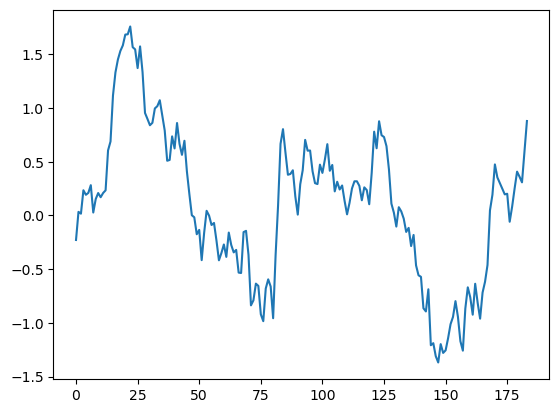

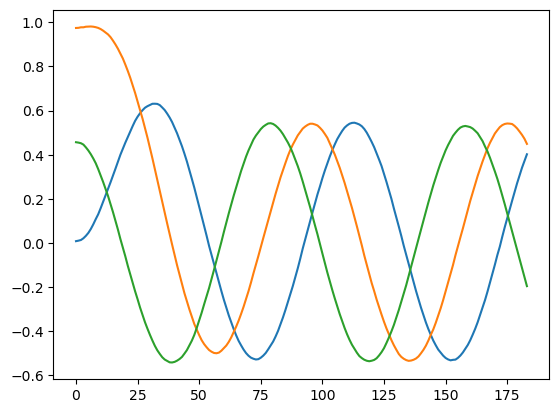

In [3]:
# This is what a single channel, single trial looks like
plt.plot(data[0, :, 0].to("cpu"))
plt.show()

# And some channel means across all trials
plt.plot(torch.mean(data[:, :, 0], axis=0).to("cpu"))
plt.plot(torch.mean(data[:, :, 1], axis=0).to("cpu"))
plt.plot(torch.mean(data[:, :, 2], axis=0).to("cpu"))
plt.show()

In [4]:
# Now we chunk the data up into the runway (x) versus predicted portion (y)
runways = data[:, :RUNWAY_LENGTH, :]
y = data[:, RUNWAY_LENGTH:, :]

# Then make a train versus test set
runways_train = runways[:TRAIN_SET_SIZE, :, :]
y_train = y[:TRAIN_SET_SIZE, :, :]
runways_test = runways[TRAIN_SET_SIZE:, :, :]
y_test = y[TRAIN_SET_SIZE:, :, :]

# We aren't stimulating, so let's make some null stimulation descriptors
STIM_DESC_DIM = 3
stim_desc = torch.zeros(1, TRIAL_LENGTH, STIM_DESC_DIM)
stim_desc[0, :, 0] = torch.arange(TRIAL_LENGTH) / TRIAL_LENGTH
stim_desc = stim_desc[:, RUNWAY_LENGTH:, :].to(DEVICE)

stim_desc_train = stim_desc.repeat(runways_train.shape[0], 1, 1)
stim_desc_test = stim_desc.repeat(runways_test.shape[0], 1, 1)

In [6]:
# Let's make a temporal basis function model which forecasts our multidimensional time series.
# This is a tiny problem; we don't need anything complex here.
NUM_BASES = 5
LATENT_DIM = 2
BASIS_DEPTH = 2
# Regularizer weight
LAMBDA = 0.01

model = tbfm.TBFM(NUM_CHANNELS, STIM_DESC_DIM, RUNWAY_LENGTH, NUM_BASES, TRIAL_LENGTH-RUNWAY_LENGTH,
                  batchy=y_train,
                  latent_dim=LATENT_DIM,
                  basis_depth=BASIS_DEPTH,
                  device=DEVICE,
                  zscore=False,
                  normalizer=utils.ScalerQuant)
optim = model.get_optim(lr=2e-4)

# Now z score our y values using the comming means/stdevs from the training set.
# Runways are z scored by the model on the fly, and y_hats will be in that z-scored space
y_train = model.normalize(y_train)
y_test = model.normalize(y_test)

In [7]:
# Cleared for takeoff! Let's train it...

NUM_EPOCHS = 10000
TEST_EPOCH_INTERVAL = 1000  # We will run against the test set every so often to monitor progress

losses_train = []
losses_test = []

start_time = time.time()
for eidx in range(NUM_EPOCHS):
    optim.zero_grad()
    
    yhat_train = model(runways_train, stim_desc_train)
    
    loss = nn.MSELoss()(yhat_train, y_train) 
    l1w = model.get_weighting_reg()
    (loss + LAMBDA * l1w).backward()
          
    losses_train.append((eidx, loss.item()))
    optim.step()
    
    if (eidx % TEST_EPOCH_INTERVAL) == 0:        
        with torch.no_grad():
            yhat_test = model(runways_test, stim_desc_test)
    
            loss = nn.MSELoss()(yhat_test, y_test)
            losses_test.append((eidx, loss.item()))
            
        print(f"epoch: {eidx}, train loss: {losses_train[-1][1]}, test loss: {losses_test[-1][1]}")

print(f"Training time: {time.time() - start_time}")

epoch: 0, train loss: 1.6799911260604858, test loss: 1.663796067237854
epoch: 1000, train loss: 0.5805702805519104, test loss: 0.5778952240943909
epoch: 2000, train loss: 0.4752124845981598, test loss: 0.4727366864681244
epoch: 3000, train loss: 0.43102774024009705, test loss: 0.42887771129608154
epoch: 4000, train loss: 0.4119272530078888, test loss: 0.4103884994983673
epoch: 5000, train loss: 0.4093032479286194, test loss: 0.40788814425468445
epoch: 6000, train loss: 0.4089783728122711, test loss: 0.407593697309494
epoch: 7000, train loss: 0.40883395075798035, test loss: 0.4074733555316925
epoch: 8000, train loss: 0.40871480107307434, test loss: 0.4073823094367981
epoch: 9000, train loss: 0.40861988067626953, test loss: 0.40731585025787354
Training time: 157.95305347442627


<>:5: SyntaxWarning: invalid escape sequence '\h'
<>:5: SyntaxWarning: invalid escape sequence '\h'
/tmp/ipykernel_219887/2190826618.py:5: SyntaxWarning: invalid escape sequence '\h'
  plt.plot(torch.mean(yhat[:, :, ch], axis=0).detach().cpu(), "--", label="$\hat{y}$ (ch %d)" % ch, linewidth=3.0)


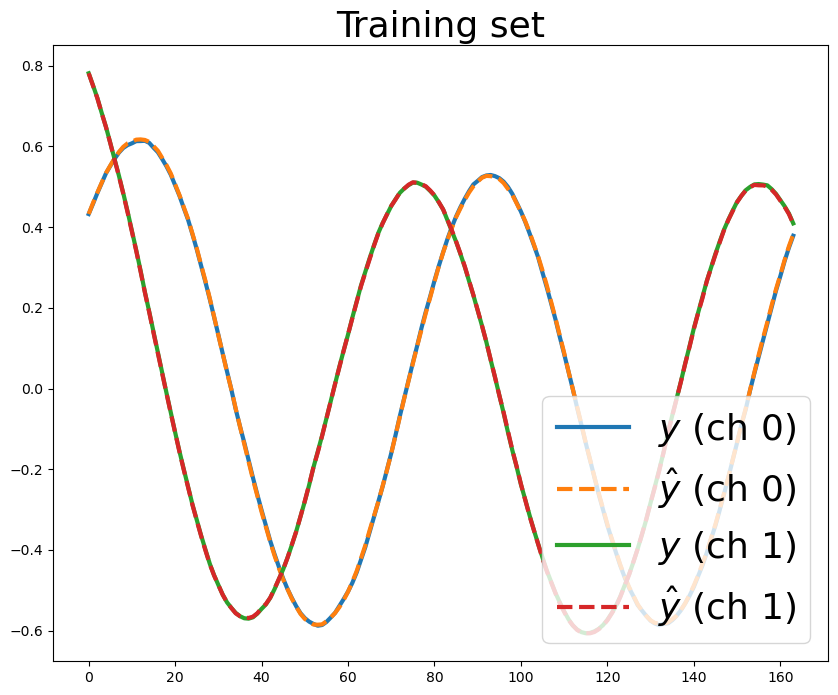

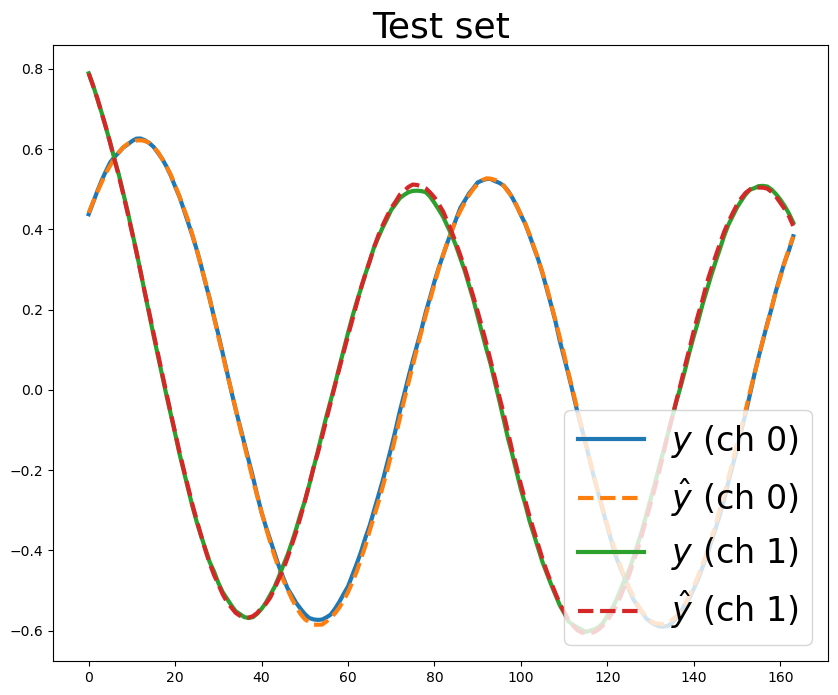

In [8]:
# Let's graph the latest set of predictions versus groundtruth for some channels

def graph_preds(y, yhat, ch):
    plt.plot(torch.mean(y[:, :, ch], axis=0).detach().cpu(), label="$y$ (ch %d)" % ch, linewidth=3.0)
    plt.plot(torch.mean(yhat[:, :, ch], axis=0).detach().cpu(), "--", label="$\hat{y}$ (ch %d)" % ch, linewidth=3.0)

plt.figure(figsize=(10, 8))
graph_preds(y_train, yhat_train, 0)
graph_preds(y_train, yhat_train, 1)
plt.legend(loc="lower right", fontsize=26)
plt.title("Training set", fontsize=26)
plt.show()

plt.figure(figsize=(10, 8))
graph_preds(y_test, yhat_test, 0)
graph_preds(y_test, yhat_test, 1)
plt.legend(loc="lower right", fontsize=24)
plt.title("Test set", fontsize=26)
plt.show()

<>:7: SyntaxWarning: invalid escape sequence '\h'
<>:7: SyntaxWarning: invalid escape sequence '\h'
/tmp/ipykernel_219887/1466071240.py:7: SyntaxWarning: invalid escape sequence '\h'
  plt.plot(yhat_train[bidx, :, 0].detach().cpu(), label="$\hat{y}$")


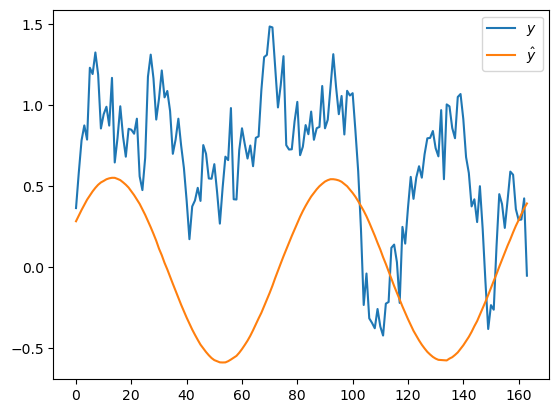

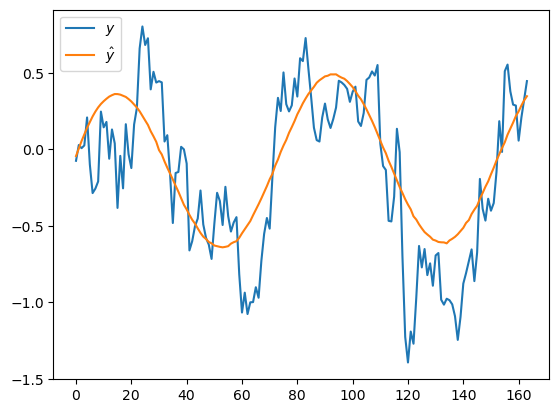

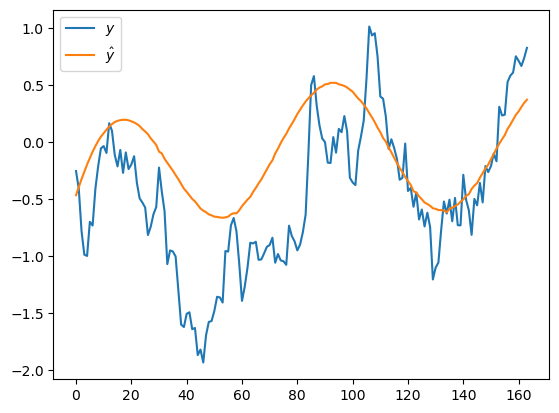

In [9]:
# This is what trials + predictions looks like. Lots of noise here makes the fit low, which is
#  a function of the noise distribution with which the OUP built the synthetic data.
# Consider altering the sigma kwarg to the data generation process to see the effect of the noise.
for _ in range(3):
    bidx = random.randrange(TRAIN_SET_SIZE)
    plt.plot(y_train[bidx, :, 0].detach().cpu(), label="$y$")
    plt.plot(yhat_train[bidx, :, 0].detach().cpu(), label="$\hat{y}$")
    plt.legend()
    plt.show()

In [11]:
# Generate a bunch of paths with OOD initial states. Let's see how we generalize...

batch_size = 500
test_ivp = torch.zeros(batch_size, TRIAL_LENGTH, NUM_CHANNELS).to(DEVICE)
iv_mean = (-1, 1, 1)
for cidx in range(NUM_CHANNELS):
    channel_data = test.generate_ou_sinusoidal_moving_mean(
        trial_len=TRIAL_LENGTH,
        batch_size=batch_size,
        phase_shift=127*cidx,
        wavelength=80,
        sigma=0.2,                  # Noise variance of the process. Raise this to make the process more stochastic.
        x0_mean=iv_mean[cidx],      # Mean of initial value distribution
    ).squeeze()
    test_ivp[:, :, cidx] = channel_data
    
test_ivp_runways = test_ivp[:, :RUNWAY_LENGTH, :]
test_ivp_y = model.normalize(test_ivp[:, RUNWAY_LENGTH:, :])

with torch.no_grad():
    test_ivp_hat = model(test_ivp_runways, stim_desc)

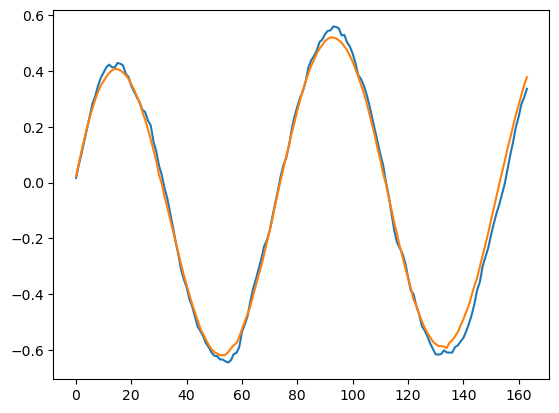

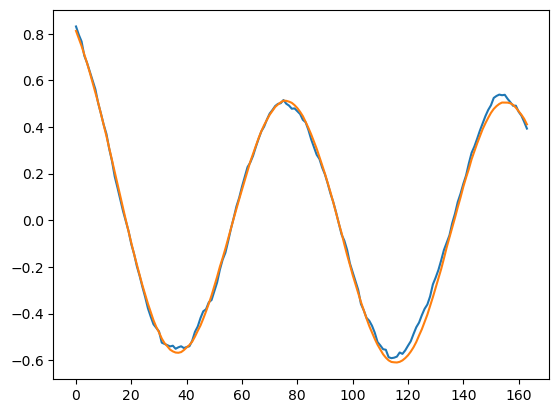

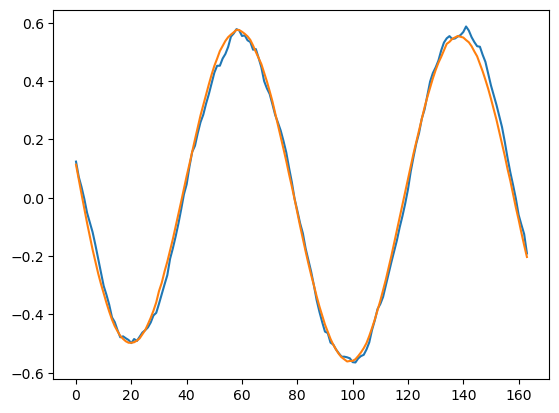

In [12]:
for cidx in range(NUM_CHANNELS):
    plt.plot(test_ivp_y.mean(dim=0)[:, cidx].cpu())
    plt.plot(test_ivp_hat.mean(dim=0)[:, cidx].cpu())
    plt.show()

<>:12: SyntaxWarning: invalid escape sequence '\h'
<>:12: SyntaxWarning: invalid escape sequence '\h'
/tmp/ipykernel_219887/2591529200.py:12: SyntaxWarning: invalid escape sequence '\h'
  ax.plot(tivp_mean_hat[:, 0], tivp_mean_hat[:, 1], tivp_mean_hat[:, 2], '--', label="Trial avg pred ($\hat{y}$)", linewidth=2)


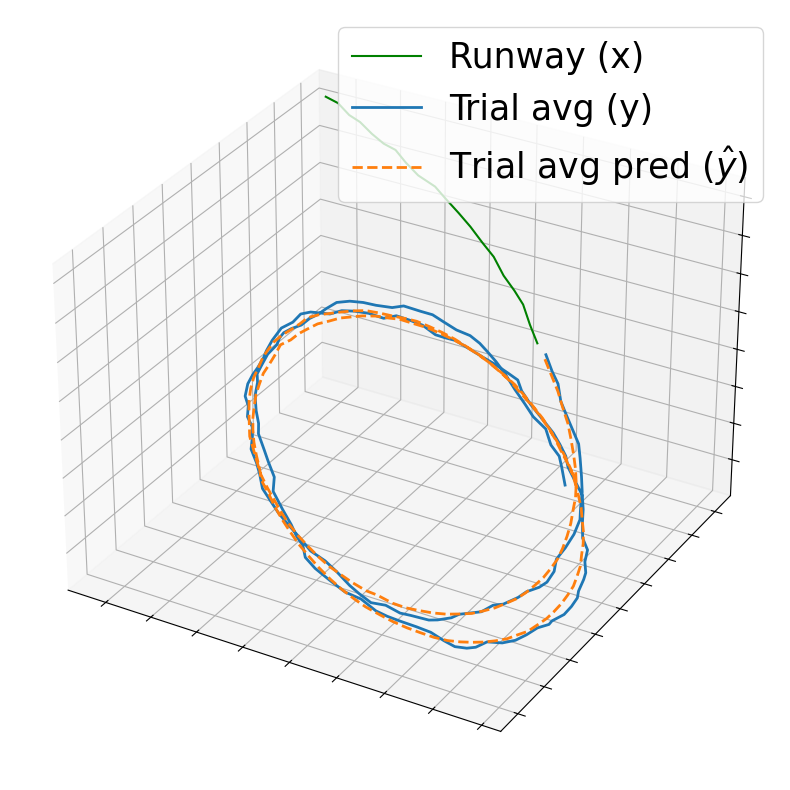

In [13]:
tivp_graph = test_ivp.cpu().numpy()
tivp_mean_runway = model.normalize(test_ivp_runways).mean(dim=0).cpu().numpy()
tivp_mean = test_ivp_y.mean(dim=0).cpu().numpy()
tivp_mean_hat = test_ivp_hat.mean(dim=0).cpu().numpy()

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot the path
ax.plot(tivp_mean_runway[:, 0], tivp_mean_runway[:, 1], tivp_mean_runway[:, 2], color='g', label="Runway (x)")
ax.plot(tivp_mean[:, 0], tivp_mean[:, 1], tivp_mean[:, 2], label="Trial avg (y)", linewidth=2)
ax.plot(tivp_mean_hat[:, 0], tivp_mean_hat[:, 1], tivp_mean_hat[:, 2], '--', label="Trial avg pred ($\hat{y}$)", linewidth=2)
ax.set_xticklabels('')
ax.set_yticklabels('')
ax.set_zticklabels('')
plt.legend(fontsize=25)

# Display the plot
plt.savefig("ou_3d_exmaple.png", dpi=300)
plt.show()

/home/mmattb/Projects/tbfm_multisession/py-tbfm/tbfm/test.py:99: RuntimeWarning: overflow encountered in cast
  minval = min(minval, min(m))
/home/mmattb/Projects/tbfm_multisession/py-tbfm/tbfm/test.py:100: RuntimeWarning: overflow encountered in cast
  maxval = max(maxval, max(m))


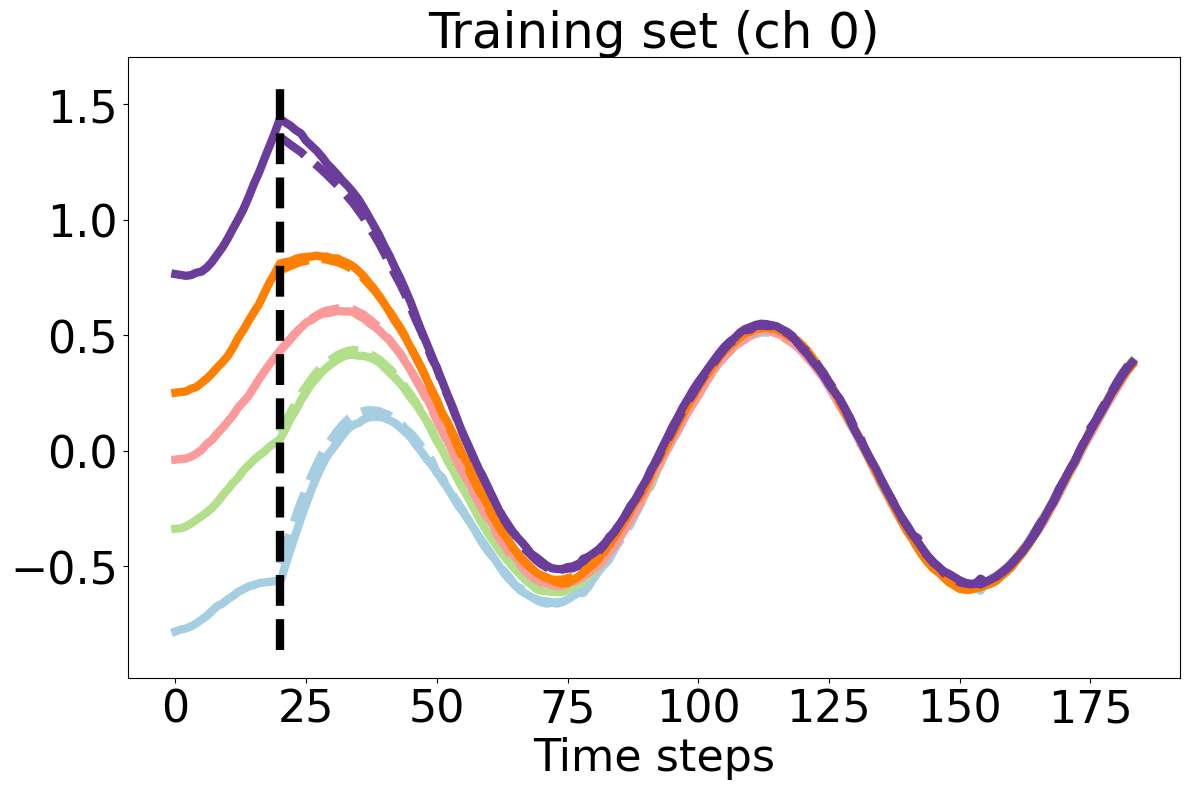

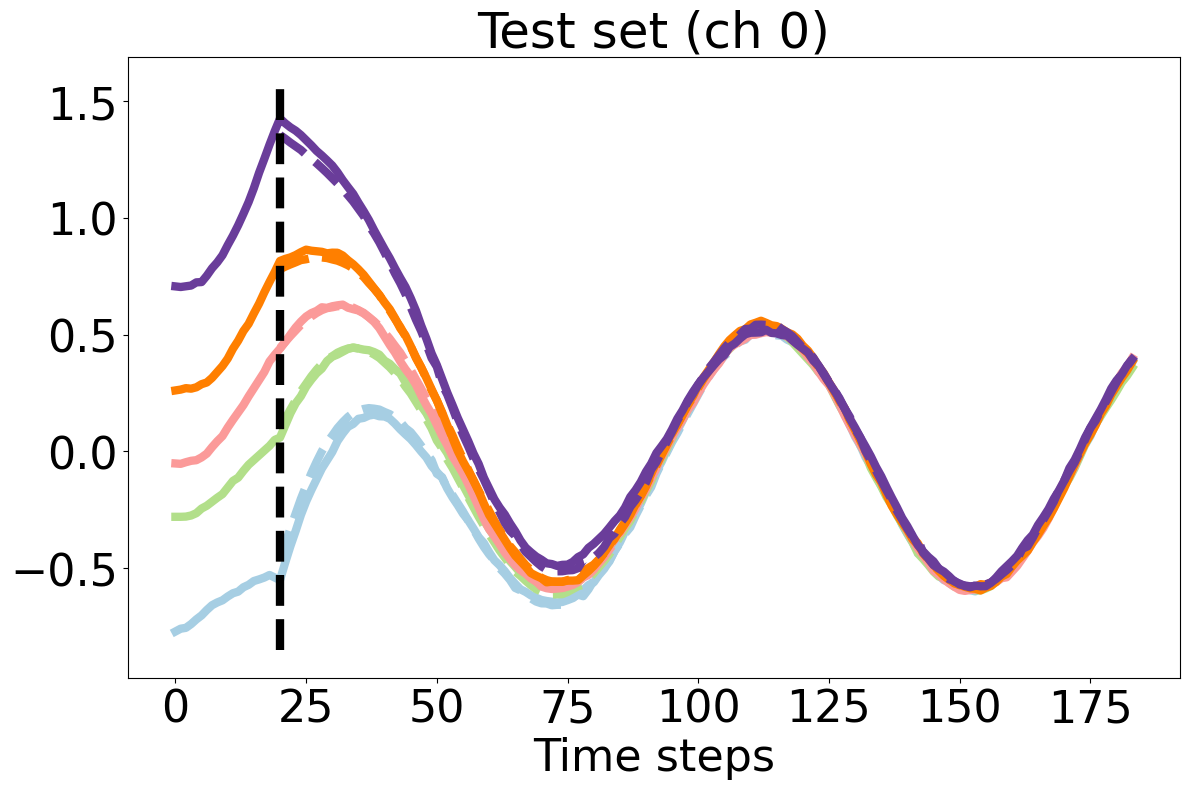

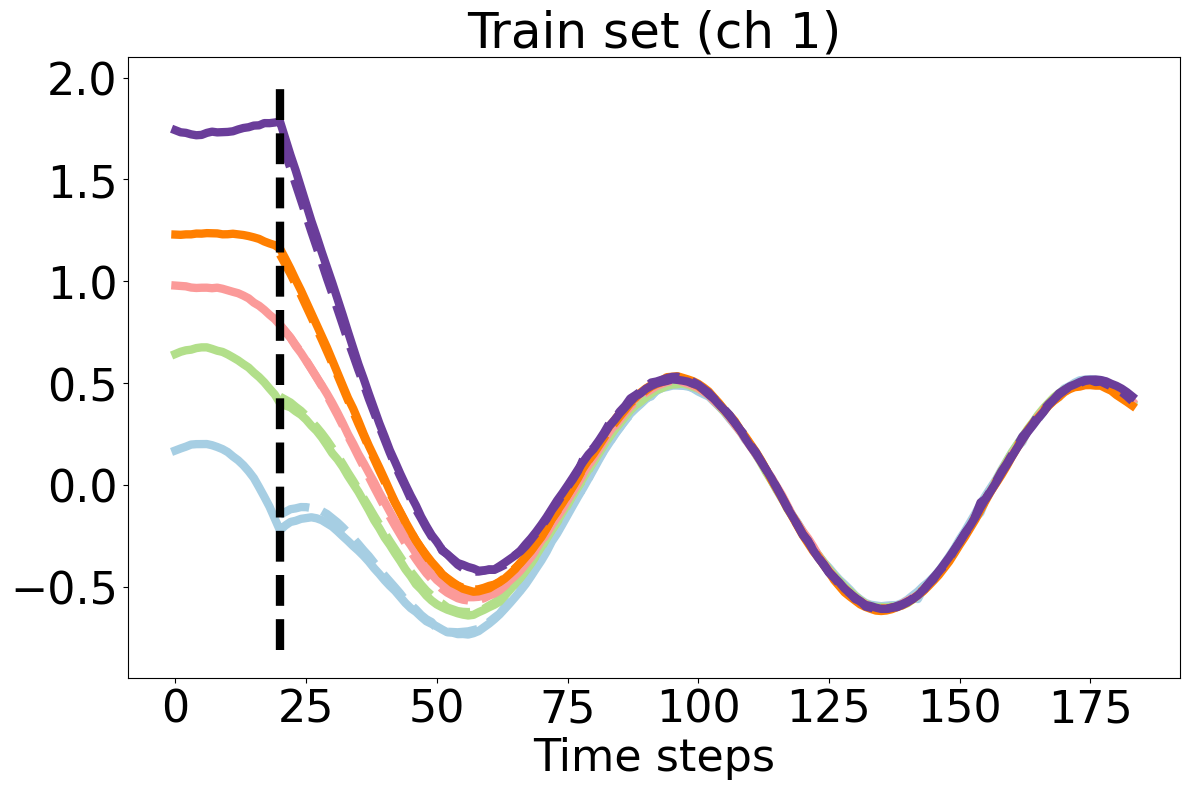

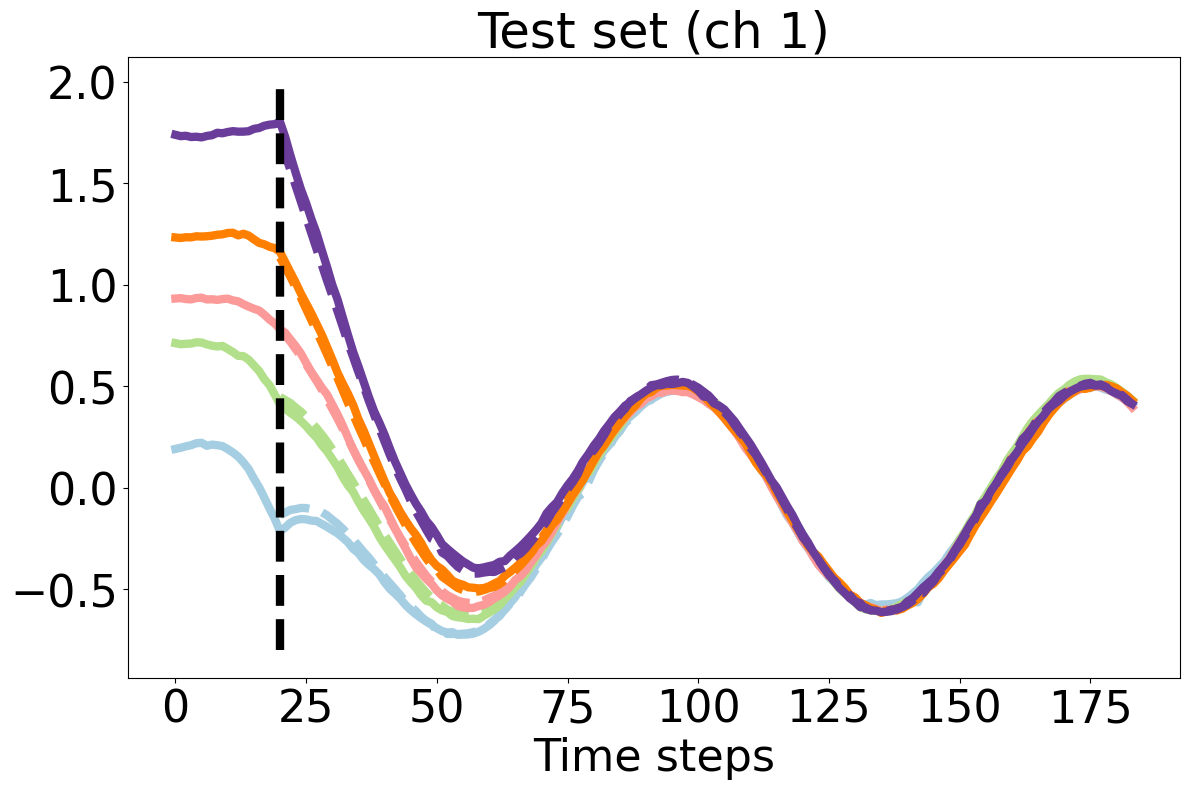

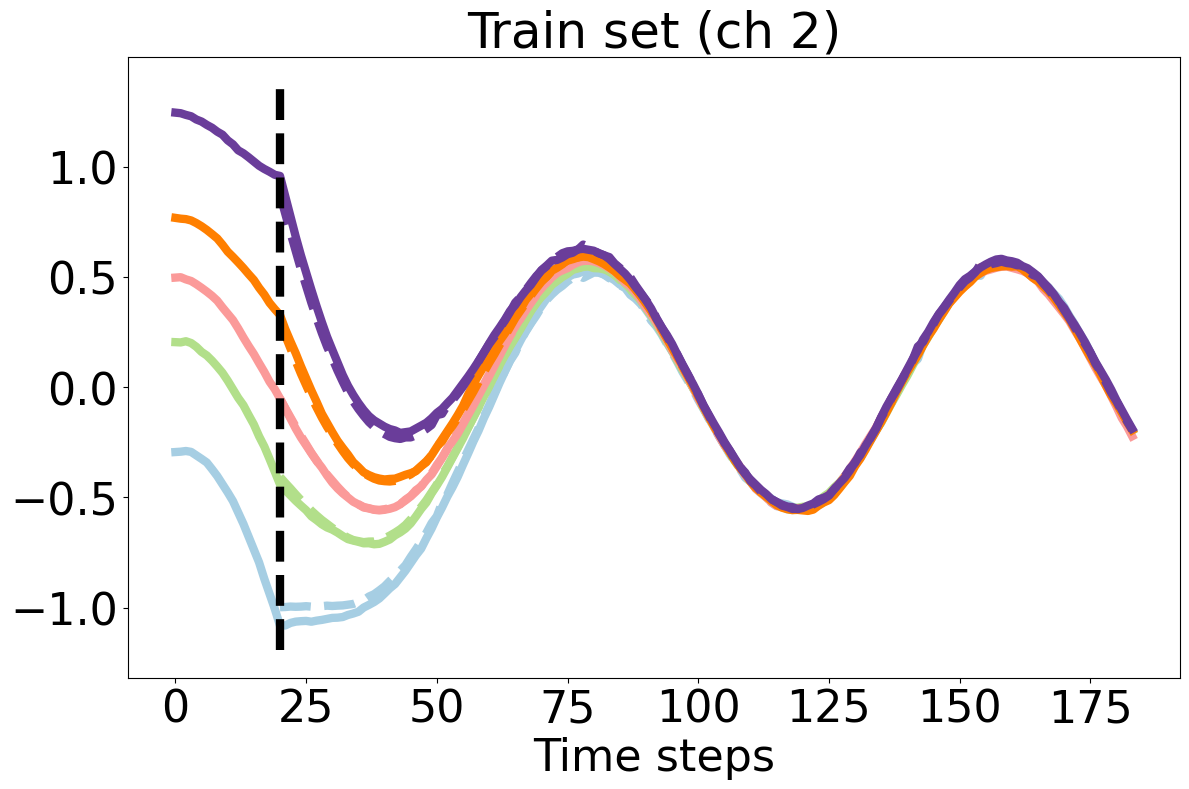

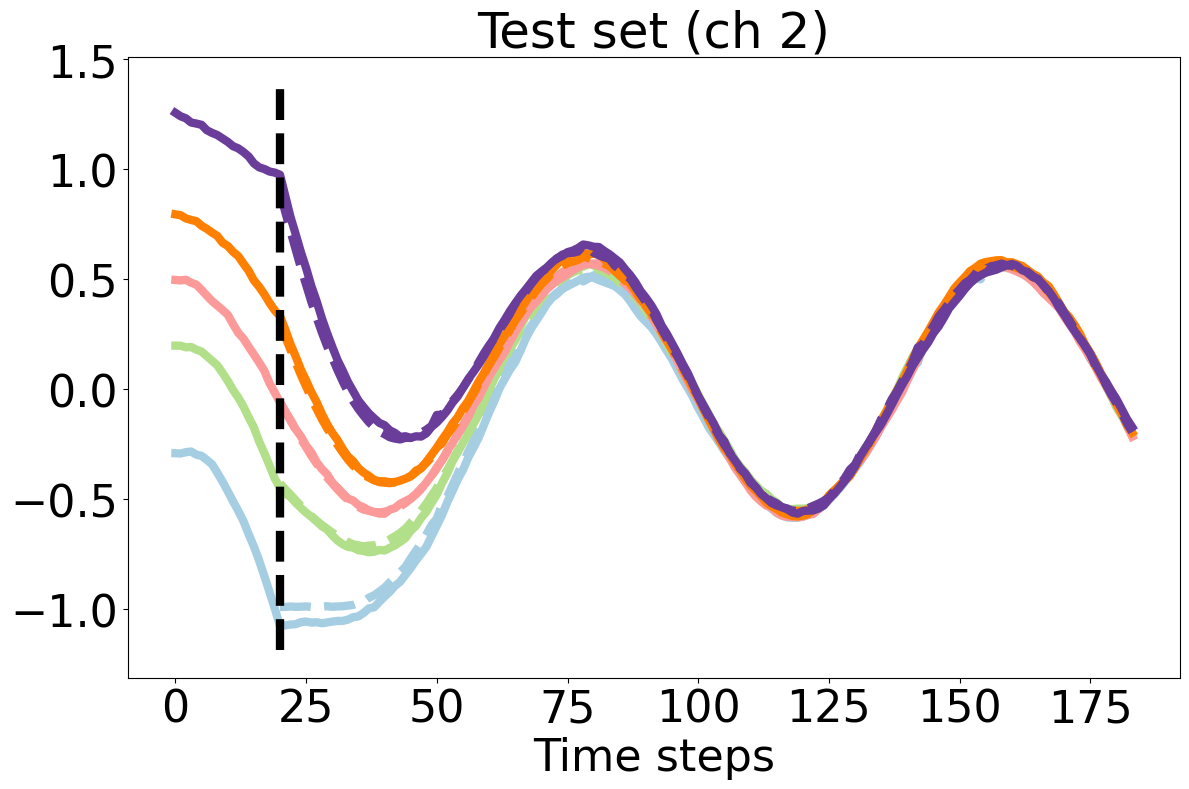

In [14]:
# Now to understand the state dependence of the predictions let's graph the mean predictions as a function of a
#   discretized state, versus groundtruth.

# We discretize the state at t=RUNWAY_LENGTH into bins, and show the mean prediction and
#   mean groundtruth for each bin. The bins are constructed using percentiles so we have
#   an equal number of trials in each.

# This is a complex graphing function so we outsource the logic to test.graph_state_dependency;
#   see details there.

bin_count = 5
full_y_train = model.normalize(data[:TRAIN_SET_SIZE, :, :].to(DEVICE))
test.graph_state_dependency(full_y_train, yhat_train, ch=0, runway_length=RUNWAY_LENGTH,
                            bin_count=bin_count, title="Training set (ch 0)")

full_y_test = model.normalize(data[TRAIN_SET_SIZE:, :, :].to(DEVICE))
test.graph_state_dependency(full_y_test, yhat_test, ch=0, runway_length=RUNWAY_LENGTH,
                            bin_count=bin_count, title="Test set (ch 0)")


test.graph_state_dependency(full_y_train, yhat_train, ch=1, runway_length=RUNWAY_LENGTH,
                            bin_count=bin_count, title="Train set (ch 1)")
test.graph_state_dependency(full_y_test, yhat_test, ch=1, runway_length=RUNWAY_LENGTH,
                            bin_count=bin_count, title="Test set (ch 1)")

test.graph_state_dependency(full_y_train, yhat_train, ch=2, runway_length=RUNWAY_LENGTH,
                            bin_count=bin_count, title="Train set (ch 2)")
test.graph_state_dependency(full_y_test, yhat_test, ch=2, runway_length=RUNWAY_LENGTH,
                            bin_count=bin_count, title="Test set (ch 2)")

# We see the TBFM captures the essential features of the state dependence across all channels, for both
#  the training and test sets.